In [129]:
import warnings

warnings.filterwarnings(
    "ignore"
)  # For better visibility, warnings are turned off in this notebook

# ETHOS.FINE Tutorial: 2-nodal Electricity Supply System

In this application of the ETHOS.FINE framework, an energy supply system, consisting of two-regions, is modeled and optimized.

The workflow is structures as follows:
-  Required packages are imported
-  An energy system model instance is created
-  Commodity sources are added to the energy supply system model
-  Commodity conversion components are added to the energy supply system model
-  Commodity storages are added to the energy supply system model
-  Commodity transmission components are added to the energy supply system model
-  Commodity sinks are added to the energy supply system model
-  The energy supply system model is optimized
-  Selected optimization results are presented

# Import required packages

The ETHOS.FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [130]:
import fine as fn  # Provides objects and functions to model an energy system
import pandas as pd  # Used to manage data in tables
import shapely as shp  # Used to generate geometric objects
import numpy as np  # Used to generate random input data

np.random.seed(
    42
)  # Sets a "seed" to produce the same random input data in each model run

In [131]:
import geopandas as gpd  # Used to display geo-referenced plots

# Model an energy system

## Create an energy system model instance 

The structure of the energy supply system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_naturalGas_lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [132]:
# Input parameters
locations = {"regionN", "regionS"}
commodityUnitDict = {
    "electricity": r"GW$_{el}$",
    "naturalGas": r"GW$_{CH_{4},LHV}$",
    "CO2": r"Mio. t$_{CO_2}$/h",
}
commodities = {"electricity", "naturalGas", "CO2"}
numberOfTimeSteps, hoursPerTimeStep = 8760, 1
costUnit, lengthUnit = "1e6 Euro", "km"

# Code
esM = fn.EnergySystemModel(
    locations=locations,
    commodities=commodities,
    numberOfTimeSteps=numberOfTimeSteps,
    commodityUnitsDict=commodityUnitDict,
    hoursPerTimeStep=hoursPerTimeStep,
    costUnit=costUnit,
    lengthUnit=lengthUnit,
    verboseLogLevel=0,
)

## Add source components

Source components generate commodities across the energy system's virtual boundaries.

In [133]:
# Input parameters
name, commodity = "Wind turbines", "electricity"
hasCapacityVariable = True
operationRateMax = pd.DataFrame(
    [[np.random.beta(a=2, b=7.5), np.random.beta(a=2, b=9)] for t in range(8760)],
    index=range(8760),
    columns=["regionN", "regionS"],
).round(6)
capacityMax = pd.Series([400, 200], index=["regionN", "regionS"])
investPerCapacity, opexPerCapacity = 1200, 1200 * 0.02
interestRate, economicLifetime = 0.08, 20

# If data should be read from an excel file:
writer = pd.ExcelWriter("windTurbineProfile.xlsx")  # writes data to an excel file
operationRateMax.to_excel(writer)  # (not required if excel file
writer.close()  #  already exists)
operationRateMax = pd.read_excel(
    "windTurbineProfile.xlsx", index_col=0
)  # reads an excel file located in
# the current working directory

# Code
esM.add(
    fn.Source(
        esM=esM,
        name=name,
        commodity=commodity,
        hasCapacityVariable=hasCapacityVariable,
        operationRateMax=operationRateMax,
        capacityMax=capacityMax,
        investPerCapacity=investPerCapacity,
        opexPerCapacity=opexPerCapacity,
        interestRate=interestRate,
        economicLifetime=economicLifetime,
    )
)

In [134]:
# Input parameters
name, commodity = "PV", "electricity"
hasCapacityVariable = True
dailyProfileSimple = [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0.05,
    0.15,
    0.2,
    0.4,
    0.8,
    0.7,
    0.4,
    0.2,
    0.15,
    0.05,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
]
operationRateMax = pd.DataFrame(
    [[u, u] for day in range(365) for u in dailyProfileSimple],
    index=range(8760),
    columns=["regionN", "regionS"],
)
capacityMax = pd.Series([100, 100], index=["regionN", "regionS"])
investPerCapacity, opexPerCapacity = 800, 800 * 0.02
interestRate, economicLifetime = 0.08, 25

# If data should be read from an excel file:
writer = pd.ExcelWriter("PV_Profile.xlsx")  # writes data to an excel file
operationRateMax.to_excel(writer)  # (not required if excel file
writer.close()  #  already exists)
operationRateMax = pd.read_excel(
    "PV_Profile.xlsx", index_col=0
)  # reads an excel file located in
# the current working directory

# Code
esM.add(
    fn.Source(
        esM=esM,
        name=name,
        commodity=commodity,
        hasCapacityVariable=hasCapacityVariable,
        operationRateMax=operationRateMax,
        capacityMax=capacityMax,
        investPerCapacity=investPerCapacity,
        opexPerCapacity=opexPerCapacity,
        interestRate=interestRate,
        economicLifetime=economicLifetime,
    )
)

In [135]:
# Input parameters
name, commodity = "Natural gas import", "naturalGas"
hasCapacityVariable = False
commodityCost = 0.03

# Code
esM.add(
    fn.Source(
        esM=esM,
        name=name,
        commodity=commodity,
        hasCapacityVariable=hasCapacityVariable,
        commodityCost=commodityCost,
    )
)

##  Add conversion components

Conversion components convert m commodities into n other commodities.

In [136]:
# Input parameters
name, physicalUnit = "Gas power plants", r"GW$_{el}$"
commodityConversionFactors = {
    "electricity": 1,
    "naturalGas": -1 / 0.63,
    "CO2": 201 * 1e-6 / 0.63,
}
hasCapacityVariable = True
investPerCapacity, opexPerCapacity = 650, 650 * 0.03
interestRate, economicLifetime = 0.08, 30

# Code
esM.add(
    fn.Conversion(
        esM=esM,
        name=name,
        physicalUnit=physicalUnit,
        commodityConversionFactors=commodityConversionFactors,
        hasCapacityVariable=hasCapacityVariable,
        investPerCapacity=investPerCapacity,
        opexPerCapacity=opexPerCapacity,
        interestRate=interestRate,
        economicLifetime=economicLifetime,
    )
)

## Add storage components

Storage components can store commodities across time steps.

The self discharge of a storage technology is described in FINE in percent per hour. If the literature value is given in percent per month, e.g. 3%/month, the self discharge per hours is obtained using the equation (1-$\text{selfDischarge}_\text{hour})^{30*24\text{h}} = 1-\text{selfDischarge}_\text{month}$.

In [137]:
# Input parameters
name, commodity = "Batteries", "electricity"
hasCapacityVariable = True
chargeEfficiency, dischargeEfficiency, selfDischarge = (
    0.95,
    0.95,
    1 - (1 - 0.03) ** (1 / (30 * 24)),
)
chargeRate, dischargeRate = 1, 1
investPerCapacity, opexPerCapacity = 150, 150 * 0.01
interestRate, economicLifetime, cyclicLifetime = 0.08, 22, 12000

# Code
esM.add(
    fn.Storage(
        esM=esM,
        name=name,
        commodity=commodity,
        hasCapacityVariable=hasCapacityVariable,
        chargeEfficiency=chargeEfficiency,
        cyclicLifetime=cyclicLifetime,
        dischargeEfficiency=dischargeEfficiency,
        selfDischarge=selfDischarge,
        chargeRate=chargeRate,
        dischargeRate=dischargeRate,
        investPerCapacity=investPerCapacity,
        opexPerCapacity=opexPerCapacity,
        interestRate=interestRate,
        economicLifetime=economicLifetime,
    )
)

## Add transmission components

Transmission components transmit commodities between regions.

In [138]:
# Input parameters
name, commodity = "AC cables", "electricity"
hasCapacityVariable = True
capacityFix = pd.DataFrame(
    [[0, 30], [30, 0]], columns=["regionN", "regionS"], index=["regionN", "regionS"]
)
distances = pd.DataFrame(
    [[0, 400], [400, 0]], columns=["regionN", "regionS"], index=["regionN", "regionS"]
)
losses = 0.0001

# Code
esM.add(
    fn.Transmission(
        esM=esM,
        name=name,
        commodity=commodity,
        hasCapacityVariable=hasCapacityVariable,
        capacityFix=capacityFix,
        distances=distances,
        losses=losses,
    )
)

In [139]:
distances

regionN  regionS
regionN        0      400
regionS      400        0

## Add sink components

Sinks remove commodities across the energy system´s virtual boundaries.

In [140]:
# Input parameters
name, commodity = (
    "Electricity demand",
    "electricity",
)
hasCapacityVariable = False
dailyProfileSimple = [
    0.6,
    0.6,
    0.6,
    0.6,
    0.6,
    0.7,
    0.9,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0.9,
    0.8,
]
operationRateFix = pd.DataFrame(
    [
        [(u + 0.1 * np.random.rand()) * 25, (u + 0.1 * np.random.rand()) * 40]
        for day in range(365)
        for u in dailyProfileSimple
    ],
    index=range(8760),
    columns=["regionN", "regionS"],
).round(2)

# If data should be read from an excel file:
writer = pd.ExcelWriter("demandProfile.xlsx")  # writes data to an excel file
operationRateFix.to_excel(writer)  # (not required if excel file
writer.close()  #  already exists)
operationRateFix = pd.read_excel(
    "demandProfile.xlsx", index_col=0
)  # reads an excel file located in
# the current working directory

# Code
esM.add(
    fn.Sink(
        esM=esM,
        name=name,
        commodity=commodity,
        hasCapacityVariable=hasCapacityVariable,
        operationRateFix=operationRateFix,
    )
)

In [141]:
# Input parameters
name, commodity = (
    "CO2 to environment",
    "CO2",
)
hasCapacityVariable = False
commodityLimitID, yearlyLimit = "CO2 limit", 366 * (1 - 0.8)

# Code
if yearlyLimit > 0:
    esM.add(
        fn.Sink(
            esM=esM,
            name=name,
            commodity=commodity,
            hasCapacityVariable=hasCapacityVariable,
            commodityLimitID=commodityLimitID,
            yearlyLimit=yearlyLimit,
        )
    )

In [198]:
esM.updateComponent("CO2 to environment", {"yearlyLimit": 2})

# Optimize energy system model

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

In [199]:
# Input parameters
numberOfTypicalPeriods = 30

# Code
esM.aggregateTemporally(numberOfTypicalPeriods=numberOfTypicalPeriods)


Clustering time series data with 30 typical periods and 24 time steps per period 
further clustered to 12 segments per period...
		(9.1191 sec)



In [200]:
# Input parameters
timeSeriesAggregation = True
solver = "gurobi"

# Code
esM.optimize(timeSeriesAggregation=timeSeriesAggregation, solver=solver)

Time series aggregation specifications:
Number of typical periods:30, number of time steps per period:24, number of segments per period:12

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.5384 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.1022 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.0264 sec)

Declaring sets, variables and constraints for TransmissionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.2267 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring linked component quantity constraint...
		(0.0000 sec)

Declaring commodity balances...
		(0.1997 sec)

		(0.0000 sec)

Declaring objective function...
		(0.9840 sec)

Set parameter Username
Aca

# Output of selected results

For the assessment of the optimization result, several result output functions are available. They can be categorized into output in form of tables, geo-referenced output visualization and the full time series visualization.


## Create a regional shape file and visualize it

Information on the geometrical shape of the investigated regions can either be downloaded from a website (e.g. from https://gadm.org/) or manually created. In this notebook, the geometries are manually created.

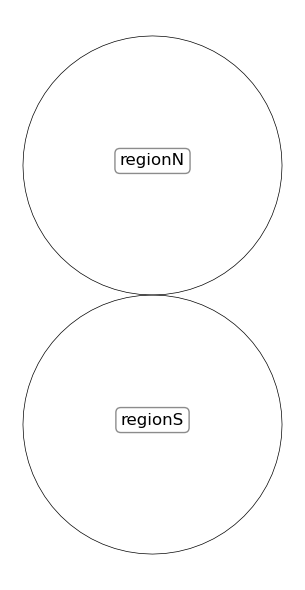

In [201]:
# Create two circles, representing the two regions, and store their geometries in a shape file
shpRegionS = shp.geometry.Point(0.5, 0.5).buffer(0.5)
shpRegionN = shp.geometry.Point(0.5, 1.5).buffer(0.5)
regionsGdf = gpd.GeoDataFrame(
    {"geometry": [shpRegionN, shpRegionS], "regionName": ["regionN", "regionS"]},
    index=["regionN", "regionS"],
    crs="epsg:3035",
)
regionsGdf.to_file("regions.shp")

# Create a line, representing the connection between the two regions, and store its geometry in a
# shape file
lines = shp.geometry.LineString([(0.5, 0.5), (0.5, 1.5)])
linesGdf = gpd.GeoDataFrame(
    {
        "geometry": [lines, lines],
        "loc0": ["regionN", "regionS"],
        "loc1": ["regionS", "regionN"],
    },
    index=["regionN_regionS", "regionS_regionN"],
    crs="epsg:3035",
)
linesGdf.to_file("lines.shp")

# Visualize the geometric representation of the two regions
fig, ax = fn.plotLocations("regions.shp", indexColumn="regionName", plotLocNames=True)

## Display optimization summaries

For each modeling class, an optimization summary can be stored and displayed. 

In [202]:
esM.getComponentAttribute("CO2 to environment", "yearlyLimit")

2

In [203]:
srcSnkSummary_1 = esM.getOptimizationSummary("SourceSinkModel", outputLevel=1)
srcSnkSummary_2 = esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)
display(esM.getOptimizationSummary("SourceSinkModel", outputLevel=1))
display(esM.getOptimizationSummary("SourceSinkModel", outputLevel=2))

regionN  \
Component          Property                        Unit                                     
CO2 to environment NPVcontribution                 [1e6 Euro]                         0.0   
                   TAC                             [1e6 Euro/a]                       0.0   
                   commodCosts                     [1e6 Euro/a]                       0.0   
                   commodRevenues                  [1e6 Euro/a]                       0.0   
                   operation                       [Mio. t$_{CO_2}$/h*h/a]            0.0   
                                                   [Mio. t$_{CO_2}$/h*h]              0.0   
                   opexOp                          [1e6 Euro/a]                       0.0   
Electricity demand NPVcontribution                 [1e6 Euro]                         0.0   
                   TAC                             [1e6 Euro/a]                       0.0   
                   commodCosts                     [1e6 Euro/a]                       0.0   
                   commodRevenues                  [1e6 Euro/a]                       0.0   
                   operation                       [GW$_{el}$*h/a]              205207.79   
                                                   [GW$_{el}$*h]                205207.79   
                   opexOp                          [1e6 Euro/a]                       0.0   
Natural gas import NPVcontribution                 [1e6 Euro]                         0.0   
                   TAC                             [1e6 Euro/a]                       0.0   
                   commodCosts                     [1e6 Euro/a]                       0.0   
                   commodRevenues                  [1e6 Euro/a]                       0.0   
                   operation                       [GW$_{CH_{4},LHV}$*h/a]            0.0   
                                                   [GW$_{CH_{4},LHV}$*h]              0.0   
                   opexOp                          [1e6 Euro/a]                       0.0   
PV                 NPVcontribution                 [1e6 Euro]                         0.0   
                   TAC                             [1e6 Euro/a]                       0.0   
                   capacity                        [GW$_{el}$]                        0.0   
                   capexCap                        [1e6 Euro/a]                       0.0   
                   commissioning                   [GW$_{el}$]                        0.0   
                   commodCosts                     [1e6 Euro/a]                       0.0   
                   commodRevenues                  [1e6 Euro/a]                       0.0   
                   decommissioning                 [GW$_{el}$]                        0.0   
                   invest                          [1e6 Euro]                         0.0   
                   investLifetimeExtension         [1e6 Euro]                           0   
                   operation                       [GW$_{el}$*h/a]                    0.0   
                                                   [GW$_{el}$*h]                      0.0   
                   opexCap                         [1e6 Euro/a]                       0.0   
                   opexOp                          [1e6 Euro/a]                       0.0   
                   revenueLifetimeShorteningResale [1e6 Euro]                           0   
Wind turbines      NPVcontribution                 [1e6 Euro]                26005.320418   
                   TAC                             [1e6 Euro/a]              26005.320418   
                   capacity                        [GW$_{el}$]                 177.847415   
                   capexCap                        [1e6 Euro/a]              21736.982459   
                   commissioning                   [GW$_{el}$]                 177.847415   
                   commodCosts                     [1e6 Euro/a]                    

regionN  \
Component          Property        Unit                                     
CO2 to environment operation       [Mio. t$_{CO_2}$/h*h/a]            0.0   
                                   [Mio. t$_{CO_2}$/h*h]              0.0   
Electricity demand operation       [GW$_{el}$*h/a]              205207.79   
                                   [GW$_{el}$*h]                205207.79   
Natural gas import NPVcontribution [1e6 Euro]                         0.0   
                   TAC             [1e6 Euro/a]                       0.0   
                   commodCosts     [1e6 Euro/a]                       0.0   
                   operation       [GW$_{CH_{4},LHV}$*h/a]            0.0   
                                   [GW$_{CH_{4},LHV}$*h]              0.0   
PV                 NPVcontribution [1e6 Euro]                         0.0   
                   TAC             [1e6 Euro/a]                       0.0   
                   capacity        [GW$_{el}$]                        0.0   
                   capexCap        [1e6 Euro/a]                       0.0   
                   commissioning   [GW$_{el}$]                        0.0   
                   invest          [1e6 Euro]                         0.0   
                   operation       [GW$_{el}$*h/a]                    0.0   
                                   [GW$_{el}$*h]                      0.0   
                   opexCap         [1e6 Euro/a]                       0.0   
Wind turbines      NPVcontribution [1e6 Euro]                26005.320418   
                   TAC             [1e6 Euro/a]              26005.320418   
                   capacity        [GW$_{el}$]                 177.847415   
                   capexCap        [1e6 Euro/a]              21736.982459   
                   commissioning   [GW$_{el}$]                 177.847415   
                   invest          [1e6 Euro]               213416.897973   
                   operation       [GW$_{el}$*h/a]          314028.697637   
                                   [GW$_{el}$*h]            314028.697637   
                   opexCap         [1e6 Euro/a]               4268.337959   

                                                                  regionS  
Component          Property        Unit                                    
CO2 to environment operation       [Mio. t$_{CO_2}$/h*h/a]            2.0  
                                   [Mio. t$_{CO_2}$/h*h]              2.0  
Electricity demand operation       [GW$_{el}$*h/a]              328596.33  
                                   [GW$_{el}$*h]                328596.33  
Natural gas import NPVcontribution [1e6 Euro]                  298.507463  
                   TAC             [1e6 Euro/a]                298.507463  
                   commodCosts     [1e6 Euro/a]                298.507463  
                   operation       [GW$_{CH_{4},LHV}$*h/a]    9950.248756  
                                   [GW$_{CH_{4},LHV}$*h]      9950.248756  
PV                 NPVcontribution [1e6 Euro]                 6104.663689  
                   TAC             [1e6 Euro/a]               6104.663689  
                   capacity        [GW$_{el}$]                  67.126245  
                   capexCap        [1e6 Euro/a]               5030.643764  
                   commissioning   [GW$_{el}$]                  67.126245  
                   invest          [1e6 Euro]                53700.996263  
                   operation       [GW$_{el}$*h/a]           71979.801499  
                                   [GW$_{el}$*h]             71979.801499  
                   opexCap         [1e6 Euro/a]               1074.019925  
Wind turbines      NPVcontribution [1e6 Euro]                14678.334262  
                   TAC             [1e6 Euro/a]              14678.334262  
                   capacity        [GW$_{el}$]                 100.383451  
                   capexCap        [1e6 Euro/a]              12269.131441  
        

In [204]:
tac_srcsnk = srcSnkSummary_2.xs('TAC', level='Property').sum().sum()

In [205]:
co2_srcsnk = srcSnkSummary_2.xs(('operation', '[Mio. t$_{CO_2}$/h*h/a]'), level=('Property', 'Unit')).loc['CO2 to environment'].sum()

In [206]:
convSummary_1 = esM.getOptimizationSummary("ConversionModel", outputLevel=1)
convSummary_2 = esM.getOptimizationSummary("ConversionModel", outputLevel=2)
tac_conv = convSummary_2.xs('TAC', level='Property').sum().sum()
display(esM.getOptimizationSummary("ConversionModel", outputLevel=2))
display(tac_conv)

regionN      regionS
Component        Property        Unit                                
Gas power plants NPVcontribution [1e6 Euro]          0.0   453.221112
                 TAC             [1e6 Euro/a]        0.0   453.221112
                 capacity        [GW$_{el}$]         0.0     5.867864
                 capexCap        [1e6 Euro/a]        0.0   338.797759
                 commissioning   [GW$_{el}$]         0.0     5.867864
                 invest          [1e6 Euro]          0.0  3814.111768
                 operation       [GW$_{el}$*h/a]     0.0  6268.656716
                                 [GW$_{el}$*h]       0.0  6268.656716
                 opexCap         [1e6 Euro/a]        0.0   114.423353

453.22111209133936

In [207]:
storSummary_1 = esM.getOptimizationSummary("StorageModel", outputLevel=1)
storSummary_2 = esM.getOptimizationSummary("StorageModel", outputLevel=2)
tac_stor = storSummary_2.xs('TAC', level='Property').sum().sum()
display(esM.getOptimizationSummary("StorageModel", outputLevel=2))
display(tac_stor)

regionN       regionS
Component Property           Unit                                       
Batteries NPVcontribution    [1e6 Euro]         1196.51454   2091.697462
          TAC                [1e6 Euro/a]       1196.51454   2091.697462
          capacity           [GW$_{el}$*h]       73.836998      129.0788
          capexCap           [1e6 Euro/a]      1085.759043   1898.079262
          commissioning      [GW$_{el}$*h]       73.836998      129.0788
          invest             [1e6 Euro]        11075.54968  19361.820006
          operationCharge    [GW$_{el}$*h/a]  34241.478609  50721.097322
                             [GW$_{el}$*h]    34241.478609  50721.097322
          operationDischarge [GW$_{el}$*h/a]  30890.068795   45755.87933
                             [GW$_{el}$*h]    30890.068795   45755.87933
          opexCap            [1e6 Euro/a]       110.755497      193.6182

3288.2120025856784

In [208]:
transSummary_1 = esM.getOptimizationSummary("TransmissionModel", outputLevel=1)
transSummary_2 = esM.getOptimizationSummary("TransmissionModel", outputLevel=2)
display(esM.getOptimizationSummary("TransmissionModel", outputLevel=2))

regionN        regionS
Component Property      Unit            LocationIn                            
AC cables capacity      [GW$_{el}$]     regionN             NaN           30.0
                                        regionS            30.0            NaN
          commissioning [GW$_{el}$]     regionN             NaN           30.0
                                        regionS            30.0            NaN
          operation     [GW$_{el}$*h/a] regionN             NaN  138918.523164
                                        regionS     34842.73473            NaN
                        [GW$_{el}$*h]   regionN             NaN  138918.523164
                                        regionS     34842.73473            NaN

## Display regional and operational plots

Georeferenced plots as well as plots representing time series can be displayed for each component.

### Wind turbines

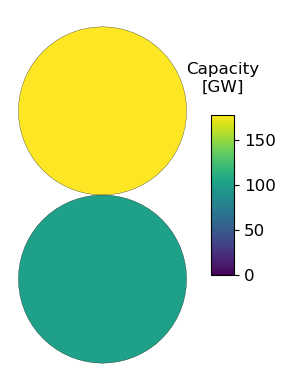

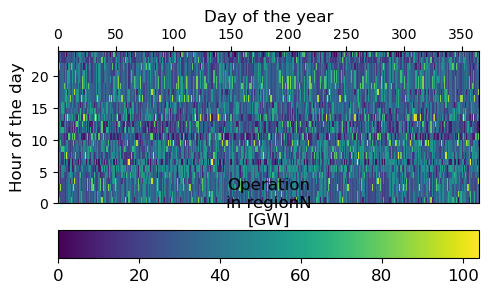

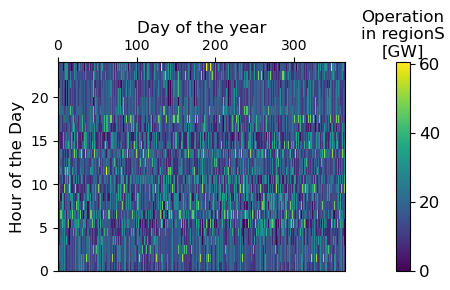

In [209]:
# If wind turbines are built, their capacities are displayed in a geo-referenced plot
if srcSnkSummary_1.loc[("Wind turbines", "capacity", "[GW$_{el}$]")].sum() > 0:
    fig, ax = fn.plotLocationalColorMap(
        esM,
        "Wind turbines",
        "regions.shp",
        "regionName",
        perArea=False,
        zlabel="Capacity\n[GW]\n",
        figsize=(4, 4),
    )
else:
    print("No wind turbines built.")

# If wind turbines are built in regionN, their operation is displayed as heatmap
if srcSnkSummary_1.loc[("Wind turbines", "capacity", "[GW$_{el}$]"), "regionN"] > 0:
    fig, ax = fn.plotOperationColorMap(
        esM,
        "Wind turbines",
        "regionN",
        figsize=(5, 3),
        xlabel="Day of the year",
        ylabel="Hour of the day",
        zlabel="Operation\nin regionN\n[GW]",
    )

# If wind turbines are built in regionS, their operation is displayed as heatmap
if srcSnkSummary_1.loc[("Wind turbines", "capacity", "[GW$_{el}$]"), "regionS"] > 0:
    fig, ax = fn.plotOperationColorMap(
        esM,
        "Wind turbines",
        "regionS",
        figsize=(5, 3),
        xlabel="Day of the year",
        ylabel="Hour of the Day",
        zlabel="Operation\nin regionS\n[GW]",
        orientation="vertical",
    )

### PV systems

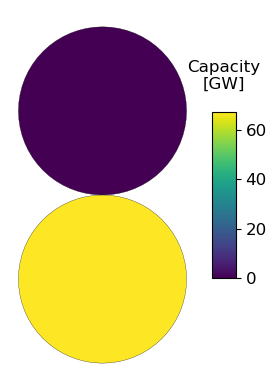

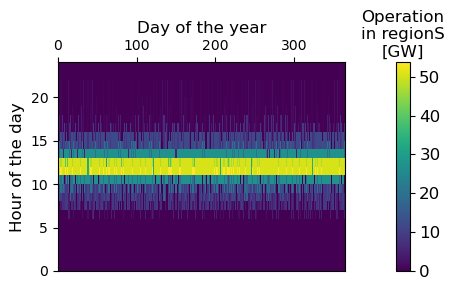

In [210]:
# If PV systems are built, their capacities are displayed in a geo-referenced plot
if srcSnkSummary_1.loc[("PV", "capacity", "[GW$_{el}$]")].sum() > 0:
    fig, ax = fn.plotLocationalColorMap(
        esM,
        "PV",
        "regions.shp",
        "regionName",
        perArea=False,
        zlabel="Capacity\n[GW]\n",
        figsize=(4, 4),
    )
else:
    print("No PV systems built.")

# If PV systems are built in regionS, their operation is displayed as heatmap
if srcSnkSummary_1.loc[("PV", "capacity", "[GW$_{el}$]"), "regionN"] > 0:
    fig, ax = fn.plotOperationColorMap(
        esM,
        "PV",
        "regionN",
        figsize=(5, 3),
        xlabel="Day of the year",
        ylabel="Hour of the day",
        zlabel="Operation\nin regionN\n[GW]",
    )

# If PV systems are built in regionS, their operation is displayed as heatmap
if srcSnkSummary_1.loc[("PV", "capacity", "[GW$_{el}$]"), "regionS"] > 0:
    fig, ax = fn.plotOperationColorMap(
        esM,
        "PV",
        "regionS",
        figsize=(5, 3),
        xlabel="Day of the year",
        ylabel="Hour of the day",
        zlabel="Operation\nin regionS\n[GW]",
        orientation="vertical",
    )

### Gas power plants

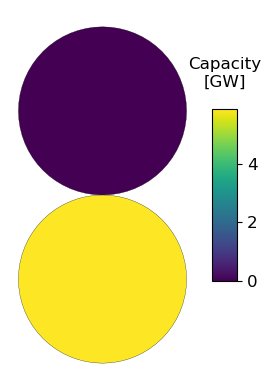

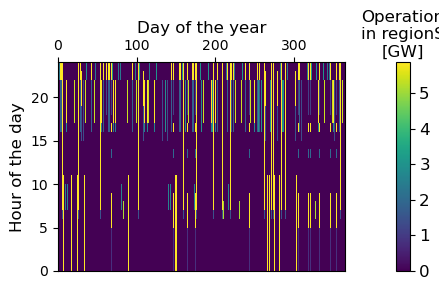

In [211]:
# If CCGT plants are built, their capacities are displayed in a geo-referenced plot
if convSummary_1.loc[("Gas power plants", "capacity", "[GW$_{el}$]")].sum() > 0:
    fig, ax = fn.plotLocationalColorMap(
        esM,
        "Gas power plants",
        "regions.shp",
        "regionName",
        perArea=False,
        zlabel="Capacity\n[GW]\n",
        figsize=(4, 4),
    )
else:
    print("No CCGT plants built.")

# If CCGT plants are built in regionS, their operation is displayed as heatmap
if convSummary_1.loc[("Gas power plants", "capacity", "[GW$_{el}$]"), "regionN"] > 0:
    fig, ax = fn.plotOperationColorMap(
        esM,
        "Gas power plants",
        "regionN",
        figsize=(5, 3),
        xlabel="Day of the year",
        ylabel="Hour of the day",
        zlabel="Operation\nin regionN\n[GW]",
        orientation="vertical",
    )

# If CCGT plants are built in regionS, their operation is displayed as heatmap
if convSummary_1.loc[("Gas power plants", "capacity", "[GW$_{el}$]"), "regionS"] > 0:
    fig, ax = fn.plotOperationColorMap(
        esM,
        "Gas power plants",
        "regionS",
        figsize=(5, 3),
        xlabel="Day of the year",
        ylabel="Hour of the day",
        zlabel="Operation\nin regionS\n[GW]",
        orientation="vertical",
    )

### Batteries

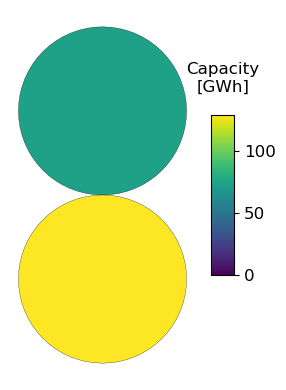

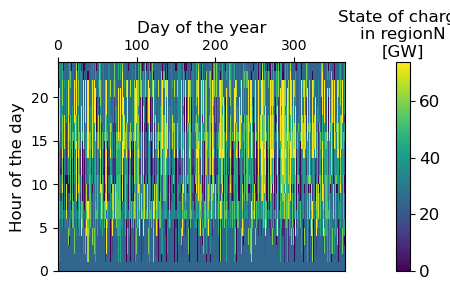

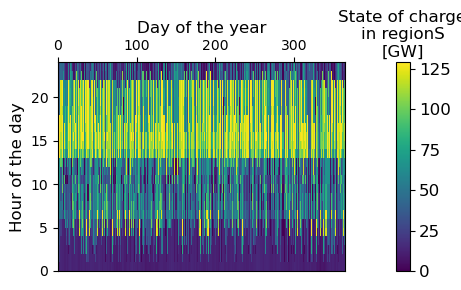

In [212]:
# If batteries are built, their capacities are displayed in a geo-referenced plot
if storSummary_1.loc[("Batteries", "capacity", "[GW$_{el}$*h]")].sum() > 0:
    fig, ax = fn.plotLocationalColorMap(
        esM,
        "Batteries",
        "regions.shp",
        "regionName",
        perArea=False,
        zlabel="Capacity\n[GWh]\n",
        figsize=(4, 4),
    )
else:
    print("No batteries built.")

# If batteries are built in regionS, their storage inventory is displayed as heatmap
if storSummary_1.loc[("Batteries", "capacity", "[GW$_{el}$*h]"), "regionN"] > 0:
    fig, ax = fn.plotOperationColorMap(
        esM,
        "Batteries",
        "regionN",
        figsize=(5, 3),
        xlabel="Day of the year",
        ylabel="Hour of the day",
        zlabel="State of charge\nin regionN\n[GW]",
        variableName="stateOfChargeOperationVariablesOptimum",
        orientation="vertical",
    )

# If batteries are built in regionS, their storage inventory is displayed as heatmap
if storSummary_1.loc[("Batteries", "capacity", "[GW$_{el}$*h]"), "regionS"] > 0:
    fig, ax = fn.plotOperationColorMap(
        esM,
        "Batteries",
        "regionS",
        figsize=(5, 3),
        xlabel="Day of the year",
        ylabel="Hour of the day",
        zlabel="State of charge\nin regionS\n[GW]",
        variableName="stateOfChargeOperationVariablesOptimum",
        orientation="vertical",
    )

### AC cables

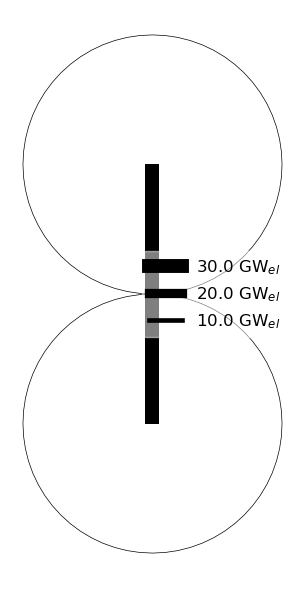

In [213]:
# The built AC cable capacities are displayed
fig, ax = fn.plotLocations("regions.shp", indexColumn="regionName")
fig, ax = fn.plotTransmission(
    esM,
    "AC cables",
    "lines.shp",
    loc0="loc0",
    loc1="loc1",
    fig=fig,
    ax=ax,
    cbHeight=0.4,
)

### Electricity demand

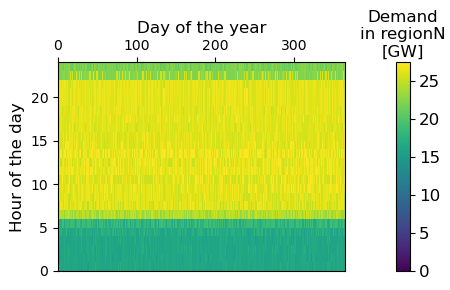

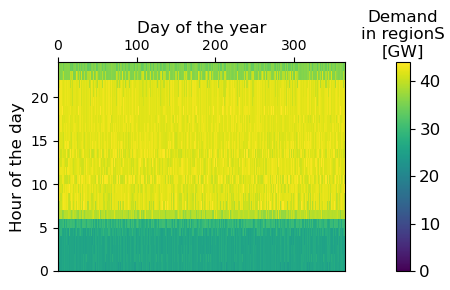

In [214]:
# The electricity demand time series in regionN is displayed
fig, ax = fn.plotOperationColorMap(
    esM,
    "Electricity demand",
    "regionN",
    figsize=(5, 3),
    xlabel="Day of the year",
    ylabel="Hour of the day",
    zlabel="Demand\nin regionN\n[GW]",
    orientation="vertical",
)

# The electricity demand time series in regionS is displayed
fig, ax = fn.plotOperationColorMap(
    esM,
    "Electricity demand",
    "regionS",
    figsize=(5, 3),
    xlabel="Day of the year",
    ylabel="Hour of the day",
    zlabel="Demand\nin regionS\n[GW]",
    orientation="vertical",
)

# Trying to alter objective function

In [215]:
esM.pyM.ConstrYearlyLimitation_srcSnk['CO2 limit', 0].upper.pprint()

2.0

In [223]:
esM.pyM.Obj.pprint()

Obj : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : minimize : (0.0*op_srcSnk[regionN,CO2 to environment,0,0,0] + 0.0*op_srcSnk[regionN,CO2 to environment,0,0,1] + 0.0*op_srcSnk[regionN,CO2 to environment,0,0,2] + 0.0*op_srcSnk[regionN,CO2 to environment,0,0,3] + 0.0*op_srcSnk[regionN,CO2 to environment,0,0,4] + 0.0*op_srcSnk[regionN,CO2 to environment,0,0,5] + 0.0*op_srcSnk[regionN,CO2 to environment,0,0,6] + 0.0*op_srcSnk[regionN,CO2 to environment,0,0,7] + 0.0*op_srcSnk[regionN,CO2 to environment,0,0,8] + 0.0*op_srcSnk[regionN,CO2 to environment,0,0,9] + 0.0*op_srcSnk[regionN,CO2 to environment,0,0,10] + 0.0*op_srcSnk[regionN,CO2 to environment,0,0,11] + 0.0*op_srcSnk[regionN,CO2 to environment,0,1,0] + 0.0*op_srcSnk[regionN,CO2 to environment,0,1,1] + 0.0*op_srcSnk[regionN,CO2 to environment,0,1,2] + 0.0*op_srcSnk[regionN,CO2 to environment,0,1,3] + 0.0*op_srcSnk[regionN,CO2 to environment,0,1,4] + 0.0*op_srcSnk[regionN,CO2 to environ

In [230]:
esM.pyM.pprint()

76 Set Declarations
    DesignLocationComponentVarSet_conv : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :    2 : {('regionS', 'Gas power plants'), ('regionN', 'Gas power plants')}
    DesignLocationComponentVarSet_srcSnk : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :    4 : {('regionN', 'Wind turbines'), ('regionS', 'Wind turbines'), ('regionN', 'PV'), ('regionS', 'PV')}
    DesignLocationComponentVarSet_stor : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :    2 : {('regionS', 'Batteries'), ('regionN', 'Batteries')}
    DesignLocationComponentVarSet_trans : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :    2 : {('regionN_regionS', 'AC cables'), ('regionS_regionN', 'AC cables')}
    chargeOpConstrSet1_stor :

esM.aggregateTemporally(numberOfTypicalPeriods=numberOfTypicalPeriods)

esM.optimize(declaresOptimizationProblem=False, timeSeriesAggregation=timeSeriesAggregation, solver=solver)

# Trying to loop optimization

In [188]:
import pyomo.environ as pyomo

def extract_tac_and_co2(esM):
    """
    Extract TAC and CO2 emissions from the esM results.
    
    Parameters:
    esM (EnergySystemModel): The energy system model instance after optimization.

    Returns:
    tuple: Total Annual Cost (TAC) and CO2 emissions.
    """
    # Get results for TAC and CO2 emissions
    
    srcSnkSummary_2 = esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)
    convSummary_2 = esM.getOptimizationSummary("ConversionModel", outputLevel=2)
    storSummary_2 = esM.getOptimizationSummary("StorageModel", outputLevel=2)

    # Initialize TAC values
    tac_srcsnk = 0
    tac_conv = 0
    tac_stor = 0
    
    # Extract TAC
    if 'TAC' in srcSnkSummary_2.index.get_level_values('Property'):
        tac_srcsnk = srcSnkSummary_2.xs('TAC', level='Property').sum().sum()
    if 'TAC' in convSummary_2.index.get_level_values('Property'):
        tac_conv = convSummary_2.xs('TAC', level='Property').sum().sum()
    if 'TAC' in storSummary_2.index.get_level_values('Property'):
        tac_stor = storSummary_2.xs('TAC', level='Property').sum().sum()
    tac = tac_srcsnk + tac_stor + tac_conv

    # Extract CO2 emissions from the "CO2 to environment" sink
    co2_srcsnk = srcSnkSummary_2.xs(('operation', '[Mio. t$_{CO_2}$/h*h/a]'), level=('Property', 'Unit')).loc['CO2 to environment'].sum()
    co2_emissions = co2_srcsnk

    return tac, co2_emissions


In [183]:
def optimize_with_new_objective(esM, weight_co2, initial_yearly_limit, maximum_tac_estimated, timeSeriesAggregation, solver='gurobi'):
    """
    Optimize a new objective that combines TAC and CO2 emissions.

    Parameters:
    esM (EnergySystemModel): The energy system model instance.
    weight_tac (float): The weight factor for TAC in the objective.
    weight_co2 (float): The weight factor for CO2 emissions in the objective.
    initial_yearly_limit (float): The initial yearly limit for CO2 emissions. Should be the maximum. Used for normalization in the objective function.
    maximum_tac_estimated (float): Used for normalization in the objective function.
    solver (str): The solver to be used (default is 'gurobi').

    Returns:
    tuple: Optimized yearly limit, TAC, CO2 emissions, and the combined objective value.
    """
    # Define the Pyomo model
    model_loop = pyomo.ConcreteModel()

    # Define the design variable for yearlyLimit
    model_loop.yearlyLimit = pyomo.Var(within=pyomo.NonNegativeReals, initialize=initial_yearly_limit/2)
    # model_loop.yearlyLimit = pyomo.Var(within=pyomo.NonNegativeReals, bounds=(0, initial_yearly_limit))


    weight_tac = 1 - weight_co2

    # Define the objective function
    def objective_rule(model_loop):
        # Set the yearly limit in the esM
        esM.updateComponent("CO2 to environment", {"yearlyLimit": model_loop.yearlyLimit.value})

        numberOfTypicalPeriods = 30
        esM.aggregateTemporally(numberOfTypicalPeriods=numberOfTypicalPeriods)

        # Re-run the optimization with the updated yearly limit
        esM.optimize(timeSeriesAggregation=timeSeriesAggregation, solver=solver)

        # Extract TAC and CO2 emissions
        tac, co2_emissions = extract_tac_and_co2(esM)

        # Combined objective
        return weight_tac * tac/maximum_tac_estimated + weight_co2 * co2_emissions/initial_yearly_limit

    model_loop.objective = pyomo.Objective(rule=objective_rule, sense=pyomo.minimize)

    # Solve the Pyomo model
    opt = pyomo.SolverFactory(solver)
    if solver == 'gurobi':
        opt.options['TimeLimit'] = 200  # seconds
    opt.solve(model_loop, tee=True) # Show solver output by adding the tee=True option when calling the solve function

    # Get the optimized results
    optimized_tac, optimized_co2_emissions = extract_tac_and_co2(esM)
    combined_objective_value = weight_tac * optimized_tac + weight_co2 * optimized_co2_emissions

    return optimized_tac, optimized_co2_emissions, combined_objective_value

In [ ]:
weight_values = np.linspace(0, 1, 10)  # Gewichtungen von 0 bis 1 in Schritten von 0.1
pareto_results = []
initial_yearly_limit = 74  # Mio. t Co2 pro Jahr
maximum_tac_estimated = 35000  # Mio. € pro Jahr

# Optimize with the new objective
for weight_co2 in weight_values:
    optimized_tac, optimized_co2_emissions, combined_objective_value = optimize_with_new_objective(esM, weight_co2, initial_yearly_limit, maximum_tac_estimated, timeSeriesAggregation, solver)
    pareto_results.append((optimized_tac, optimized_co2_emissions, combined_objective_value))

In [ ]:
initial_yearly_limit = 74  # Mio. t Co2 pro Jahr
maximum_tac_estimated = 35000  # Mio. € pro Jahr
weight_co2 = 0.5
pareto_results_test = []

optimized_tac, optimized_co2_emissions, combined_objective_value = optimize_with_new_objective(esM, weight_co2, initial_yearly_limit, maximum_tac_estimated, timeSeriesAggregation, solver)
pareto_results_test.append((optimized_tac, optimized_co2_emissions, combined_objective_value))
print(pareto_results_test)

In [ ]:
import matplotlib.pyplot as plt

# Pareto-Front plotten
pareto_df = pd.DataFrame(pareto_results_test, columns=['TAC', 'CO2 emissions', 'Total'])
pareto_df.plot(x='CO2 emissions', y='TAC', kind='scatter')
plt.xlabel('CO2 Emissions [Mio. t$_{CO_2}$/h*h/a]')
plt.ylabel('Total Annual Cost [Mio. Euro/a]')
plt.title('Pareto Front of TAC vs CO2 Emissions')
plt.show()


In [ ]:
pareto_results_test

# heuristische Optimierung möglich

## Erläuterungen:

Grobe Suche: Die Funktion erstellt zunächst eine Liste von yearlyLimit Werten und führt das Modell für jeden dieser Werte aus.
Bestimmung der besten Paare: Nach der Ausführung aller Tests sucht die Funktion das Paar aufeinanderfolgender yearlyLimit Werte mit den niedrigsten kombinierten Zielfunktionswerten.
Feine Suche: Nachdem die besten aufeinanderfolgenden Limits identifiziert wurden, wird eine detailliertere Suche in diesem engeren Bereich durchgeführt, um das optimale yearlyLimit zu bestimmen.

In [196]:
def optimization_heuristic(esM, initial_yearly_limit, num_trials, maximum_tac_estimated, weight_co2, epsilon, timeSeriesAggregation, solver):
    import numpy as np

    weight_tac = 1 - weight_co2
    
    # Schritt 1: Grobe Suche
    limits = np.linspace(1, initial_yearly_limit, num_trials)
    results = []
    
    for limit in limits:
        esM.updateComponent("CO2 to environment", {"yearlyLimit": limit})
        numberOfTypicalPeriods = 30
        esM.aggregateTemporally(numberOfTypicalPeriods=numberOfTypicalPeriods)
        esM.optimize(timeSeriesAggregation=timeSeriesAggregation, solver=solver)
        tac, co2_emissions = extract_tac_and_co2(esM)
        objective_value = weight_tac * (tac / maximum_tac_estimated) + weight_co2 * (co2_emissions / initial_yearly_limit)
        results.append((objective_value, limit, tac, co2_emissions))

    print(results)
    
    # Finde die zwei nebeneinander liegenden besten Ergebnisse
    best_pair_index = None
    best_pair_value = float('inf')
    
    for i in range(len(results) - 1):
        combined_value = results[i][0] + results[i + 1][0]
        if combined_value < best_pair_value:
            best_pair_value = combined_value
            best_pair_index = i
    
    best_two_limits = [results[best_pair_index][1], results[best_pair_index + 1][1]]
    
    # Schritt 2: Feine Suche zwischen den zwei besten Limits
    fine_limits = np.linspace(min(best_two_limits), max(best_two_limits), 20)  # Feinere Suche in einem engeren Bereich
    fine_results = []
    
    for limit in fine_limits:
        esM.updateComponent("CO2 to environment", {"yearlyLimit": limit})
        numberOfTypicalPeriods = 30
        esM.aggregateTemporally(numberOfTypicalPeriods=numberOfTypicalPeriods)
        esM.optimize(timeSeriesAggregation=timeSeriesAggregation, solver=solver)
        tac, co2_emissions = extract_tac_and_co2(esM)
        objective_value = weight_tac * (tac / maximum_tac_estimated) + weight_co2 * (co2_emissions / initial_yearly_limit)
        fine_results.append((objective_value, limit, tac, co2_emissions))
        
        if len(fine_results) > 1 and abs(fine_results[-1][0] - fine_results[-2][0]) < epsilon:
            print("Epsilon-Kriterium erreicht. Beendigung der Suche.")
            break
    
    fine_results.sort()
    print(fine_results)
    best_result = fine_results[0]
    
    print(f"Optimales yearlyLimit: {best_result[1]} mit einem Zielfunktionswert von {best_result[0]} bei einem CO2-Gewicht von {weight_co2}")
    return best_result[1]

In [197]:
initial_yearly_limit = 74  # Mio. t Co2 pro Jahr
maximum_tac_estimated = 39000  # Mio. € pro Jahr
weight_co2 = 0.1
heuristic_results_test = []

best_heuristic_result = optimization_heuristic(esM, initial_yearly_limit, 4, maximum_tac_estimated, weight_co2, 0.005, timeSeriesAggregation, solver)


Clustering time series data with 30 typical periods and 24 time steps per period 
further clustered to 12 segments per period...
		(9.4980 sec)

Time series aggregation specifications:
Number of typical periods:30, number of time steps per period:24, number of segments per period:12

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.0453 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.2122 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.8105 sec)

Declaring sets, variables and constraints for TransmissionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.1827 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring linked component quantity constraint...
		(0.000